In [1]:
import pandas as pd, numpy as np
import sys, os

sys.path.append(os.path.join(os.path.dirname('__file__'), '..', 'Scripts'))
from indicators import *
from parameters import *
from func import *
from ohlcv import *

# Suppresses SettingWithCopyWarning in Pandas
pd.options.mode.chained_assignment = None  # default='warn'

In [6]:
ohlcv = pd.read_csv('../ohlc/EURUSDH1.csv', 
                    index_col='time')

In [7]:
ohlcv = ohlcv + 0.00007

In [18]:
strat = pd.read_csv('../Results/BasicEURUSDH1.csv', 
                    index_col='time')


In [19]:
OpenEQ = pd.merge(ohlcv,strat, on='time', how='left')

OpenEQ['InitialSL'].fillna(method='ffill', inplace=True)
OpenEQ['SigPrice'].fillna(method='ffill', inplace=True)
OpenEQ['Units'].fillna(method='ffill', inplace=True)
OpenEQ['SLtime'].fillna(method='ffill', inplace=True)
OpenEQ['Profits'].fillna(method='ffill', inplace=True)
OpenEQ['StopLoss'].fillna(method='ffill', inplace=True)

OpenEQ['position'] = np.where(OpenEQ.SigPrice > OpenEQ.InitialSL, 'Buy', 'Sell')
OpenEQ['position'].fillna(method='ffill', inplace=True)

LongPnL = np.where(OpenEQ.position=='Buy',
                   (OpenEQ.close - OpenEQ.SigPrice)*(OpenEQ.Units), 0)
ShortPnL = np.where(OpenEQ.position=='Buy',
                    0, (OpenEQ.SigPrice - OpenEQ.close)*(OpenEQ.Units))

PnL = LongPnL+ShortPnL



OpenEQ['Exit'] = np.where(OpenEQ.index == OpenEQ.SLtime, 1, 0)

OpenEQ['solotradePL'] = np.where(OpenEQ.index < OpenEQ.SLtime, PnL,
                                  np.where(OpenEQ.Exit==1, OpenEQ.Profits, None))


#diff * 1st trade unit, then divide by total units, then deduct from 2nd trade
SigPriceDiff = OpenEQ.SigPrice - OpenEQ.SigPrice.shift(1)
Diff1 = SigPriceDiff * OpenEQ['Units'].shift(1)
TotalUnits = OpenEQ['Units'] + OpenEQ['Units'].shift(1)

NewSigPrice = OpenEQ['SigPrice'] - (Diff1/TotalUnits)


change = (OpenEQ.Profits != OpenEQ.Profits.shift(1))&(OpenEQ.SLtime == OpenEQ.SLtime.shift(1))

OpenEQ['NewSigPrice'] = np.where(change, NewSigPrice, None)
OpenEQ['NewSigPrice'].fillna(method='ffill', inplace=True)

NewSigUnits = OpenEQ['Units'] + OpenEQ['Units'].shift(1) 
OpenEQ['NewSigUnits'] = np.where(change, NewSigUnits, None)
OpenEQ['NewSigUnits'].fillna(method='ffill', inplace=True)

LongOpenPnL = np.where(OpenEQ.position=='Buy',
                   (OpenEQ.close - OpenEQ.NewSigPrice)*OpenEQ.NewSigUnits, 0)
ShortOpenPnL = np.where(OpenEQ.position=='Buy',
                    0, (OpenEQ.NewSigPrice - OpenEQ.close)*OpenEQ.NewSigUnits)



LongOpenExit = np.where(OpenEQ.position=='Buy',
                   (OpenEQ.StopLoss - OpenEQ.NewSigPrice)*OpenEQ.NewSigUnits, 0)
ShortOpenExit = np.where(OpenEQ.position=='Buy',
                    0, (OpenEQ.NewSigPrice - OpenEQ.StopLoss)*OpenEQ.NewSigUnits)

ExitPnL = LongOpenExit + ShortOpenExit


OpenEQ['CombRunProfits'] = LongOpenPnL + ShortOpenPnL


OpenEQ['combtradePL'] = np.where(OpenEQ.index < OpenEQ.SLtime, 
                                  np.where(change, OpenEQ.CombRunProfits, OpenEQ.solotradePL),
                                  np.where(OpenEQ.Exit==1, ExitPnL , 0)) 
                                  
OpenEQ['PLChange'] = np.where((OpenEQ.Exit==1)|(OpenEQ.Exit.shift(1)==1), 0, OpenEQ['combtradePL'] - OpenEQ['combtradePL'].shift(1))

In [20]:
#OpenEQ[580:]

In [26]:
plt.figure()
(OpenEQ['PLChange']).cumsum().plot()

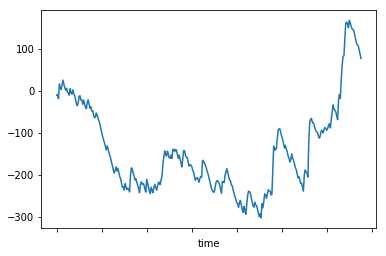

In [27]:
plt.figure()
strat.Profits.cumsum().plot()

In [22]:
#OpenEQ

In [23]:
OpenEquity = OpenEQ
OpenEquity.to_csv('../Results/UnR_EURUSDH1.csv')